# Run a full volume on the network

In [1]:
import os
from IPython.core.debugger import set_trace
from models.Mini_REDCNN import REDCNN
from utils import utils
import torch
import torch.nn as nn
import torch.utils.data.sampler as sampler
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk
import ReadWriteXML as rw

#different directories depending on the machin
pc = 'home'
pc = 'lci'

if pc == 'home':
    lr_dir = r'C:\Users\Juanig\Desktop\Codigo\ct images\Low resolution'
    net_dir = r'C:\Users\Juanig\Desktop\Codigo\ct images\3d_autoencoder_epoch_15.pkl'
else:
    lr_dir = r'C:\Users\Juan Pisula\Desktop\ct_images\patches\Low resolution'
    gt_dir = r'C:\Users\Juan Pisula\Desktop\ct_images\patches\Ground Truth'
    net_dir = r'C:\Users\Juan Pisula\Desktop\ct_images\3d_autoencoder_epoch_15.pkl'

### Load a previously trained model

In [3]:
model = REDCNN()

if torch.cuda.is_available():
    model.load_state_dict(torch.load(net_dir))
    model.cuda()
else:
    model.load_state_dict(torch.load(net_dir,map_location=lambda storage, location: storage))

model.double()
model.eval()

REDCNN(
  (enc_1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_3): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_4): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_1_deconv): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
  (dec_1_ReLU): ReLU()
  (dec_2_deconv): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
  (dec_2_ReLU): ReLU()
  (dec_3_deconv): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
  (dec_3_ReLU): ReLU()
  (dec_4_deconv): ConvTranspose3d(32, 1, kernel_size=(3, 5, 5), stride=(1, 1, 1))
)

### Open a volume and extract patches on the go
#### Things that could be improved:
- Parallel processing
- Extract patches previously

In [ ]:
#generator to get the position of a patch within the full volume
def next_index(vol, stride):
    vol_x, vol_y, vol_z = vol[0], vol[1], vol[2]
    s_x, s_y, s_z = stride[0], stride[1], stride[2]
    x = 0
    y = 0
    z = 0
    while z < vol_z:
        yield x,y,z        
        y = 0 if (y + s_y > vol_y) else y + s_y 
        x = (0 if (x + s_x > vol_x) else x + s_x) if y == 0 else x
        z = z + s_z if (x == 0) and (y == 0) else z

#patches parameters
patch_size = (23, 47, 47)
stride = (10, 20, 20)

#opening input volume
input_volume_ = rw.OpenXML(os.path.join(lr_dir, '5a_100_FBPPhil_Scan1Slices.xml'), kind = 'Slices' )
input_volume = sitk.GetArrayFromImage(input_volume_)

#initialize output volume
output_volume = np.zeros(input_volume.shape)
#since patches are overlapping, the final voxel values are gonna be averages. A mask is created to help this
mask = np.ones(input_volume.shape)

#extract patches
for i,j,k in next_index(input_volume.shape, stride):
    #initialize patch
    patch = np.zeros(patch_size) 
    #determine the max coordinates of the patch (border cases)
    i_max = min(i + patch_size[0], input_volume.shape[0] - 1)
    j_max = min(j + patch_size[1], input_volume.shape[1] - 1)
    k_max = min(k + patch_size[2], input_volume.shape[2] - 1)
    #assign patch
    patch[0: i_max - i, 0: j_max - j, 0: k_max - k] += input_volume[i:i_max, j:j_max, k:k_max]
    #skip patch if it contains any NaN values
    if (np.any(np.isnan(patch))):
        continue
    #cast to tensor
    lo_res_ = torch.from_numpy(patch)
    #adding batch and extra dimension to fit on the model
    lo_res_ = lo_res_.unsqueeze(0)
    lo_res_ = lo_res_.unsqueeze(1)
    lo_res_ = utils.var_or_cuda( lo_res_ )
    #run thru model
    net_output = model(lo_res_)
    #cast back to numpy
    output_cpu_ = net_output.detach()
    output_cpu_ = output_cpu_.cpu()
    output_cpu = output_cpu_[0][0][:][:][:]
    #assign to output volume
    output_volume[i:i_max, j:j_max, k:k_max] += output_cpu.numpy()[0: i_max - i, 0: j_max - j, 0: k_max - k]
    #update mask values
    mask[i:i_max, j:j_max, k:k_max] += np.ones(patch_size)[0: i_max - i, 0: j_max - j, 0: k_max - k]

#take the average value of overlapping patches (division by mask)
output_volume = output_volume / mask

### Plot results

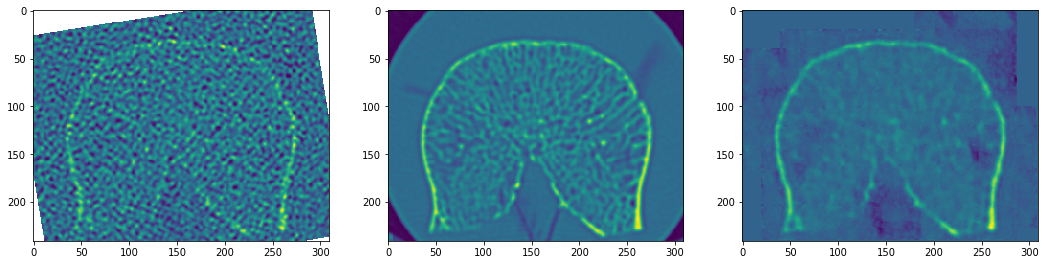

In [64]:
slc = 50
fig = plt.figure(figsize=(18, 16))
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(input_volume[slc][:][:])
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(target_volume[slc][:][:])
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(output_volume[slc][:][:])